# Projet 12

# 1 Exploration

In [3]:
import pandas as pd

df = pd.read_csv("billets.csv", sep=';')

df.head()



,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [5]:
# Statistiques de base
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [6]:

# Vérification des valeurs manquantes
df.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

### il ne semble pas y avoir de forts outliers, il y a tout de meme  du mouvement dans margin_low, il y a également 37 valeurs nulles dans margin_low

# 1.2 Implémentation

In [9]:


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# les lignes avec et sans valeurs manquantes dans 'margin_low'
df_complete = df[df['margin_low'].notnull()].copy()
df_missing = df[df['margin_low'].isnull()].copy()

# Variables explicatives (on exclut is_genuine et margin_low)
features = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

# Préparation des données pour la régression
X_train = df_complete[features]
y_train = df_complete['margin_low']

# Modèle de régression linéaire
reg = LinearRegression()
reg.fit(X_train, y_train)

# Prédire les valeurs manquantes
X_missing = df_missing[features]
predicted_values = reg.predict(X_missing)

# Remplacer les valeurs manquantes
df.loc[df['margin_low'].isnull(), 'margin_low'] = predicted_values

# Régression complète
X = df[features]
y = df['margin_low']
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred



# 2 Hypothèses pour régression linéaire


# 2.1 Linéarité

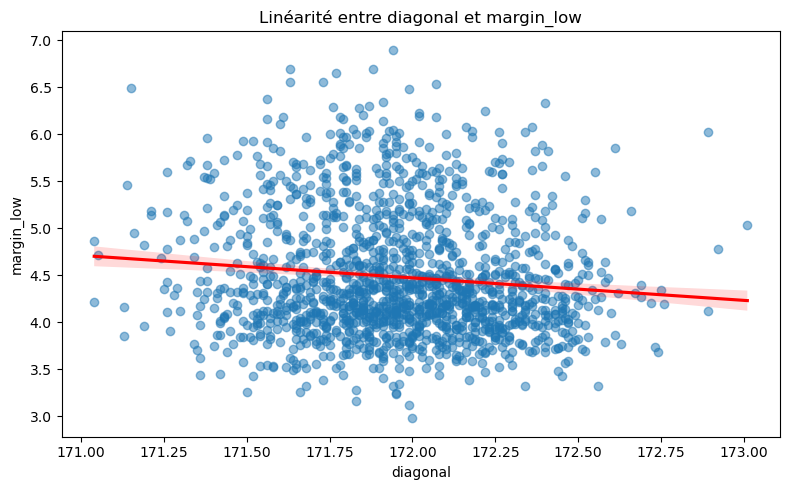

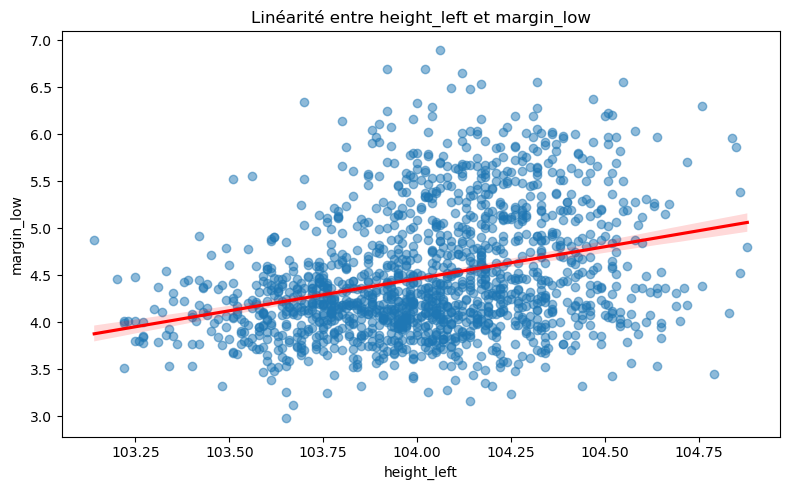

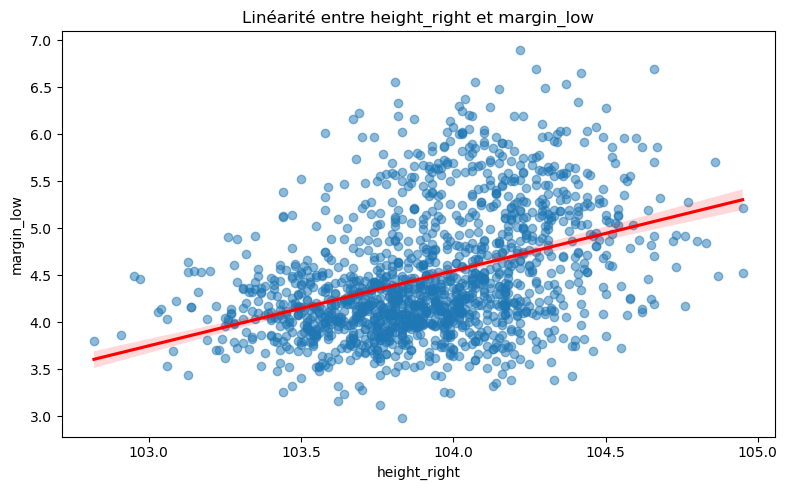

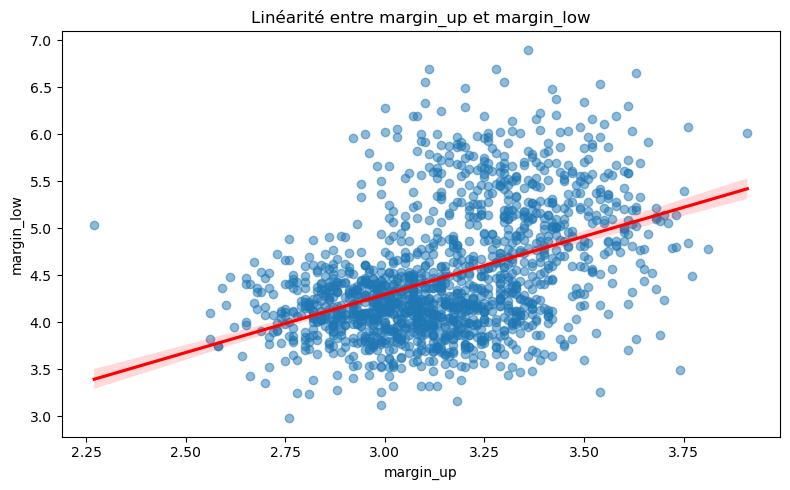

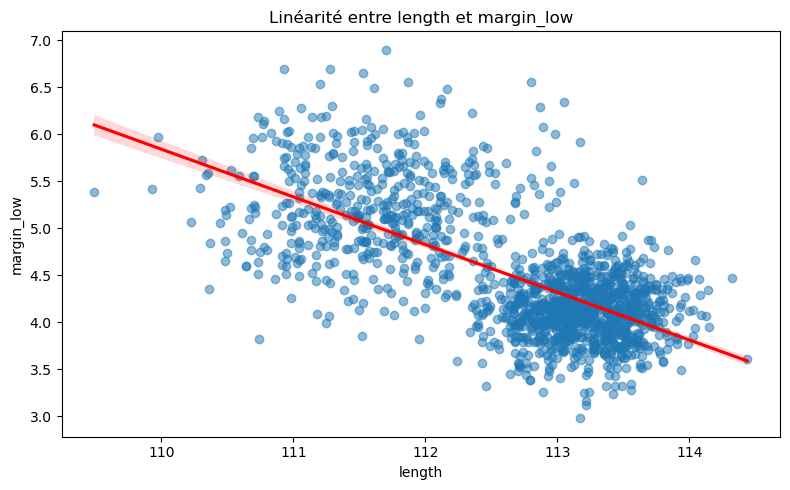

In [12]:
# 1. Linéarité - scatterplots avec courbe de tendance
for col in features:
    plt.figure(figsize=(8, 5))
    sns.regplot(x=df[col], y=y, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.title(f"Linéarité entre {col} et margin_low")
    plt.xlabel(col)
    plt.ylabel("margin_low")
    plt.tight_layout()
    plt.show()

### On cherche a déterminer si margin_low et les autres variables ont une relation linéraires



### Il y a une légere tendance droite pour chacune de variable, hypothèse validé

# 2.2 Indépendence des erreurs

In [16]:
#Hypothèse :
#Les résidus (différences entre les valeurs réelles et prédites) doivent être indépendants entre eux.

#Dans notre cas avec des billets, les données ne sont pas temporelles ni ordonnées, donc on suppose l’indépendance

# 2.3 Homoscédasticité

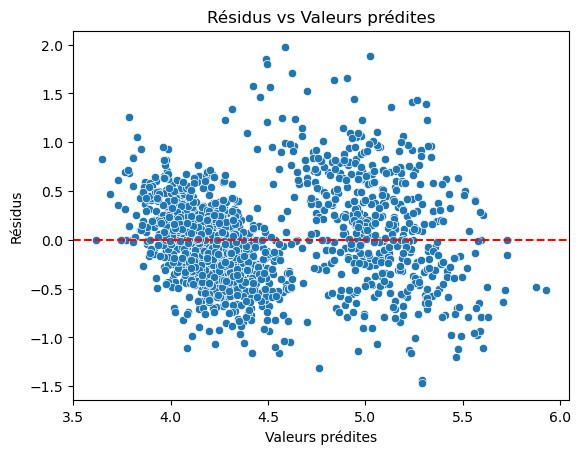

In [18]:
# Homoscédasticité
plt.figure()
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs Valeurs prédites")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.show()

In [19]:
#Hypothèse :
#La variance des résidus est constante pour toutes les valeurs prédites.

#Justification :
#On trace les résidus en fonction des valeurs prédites

#Si le nuage est horizontal et homogène, c’est bon

#Si on voit un cône ou un entonnoir, la variance n’est pas constante



### interpretation dur à l'oeil, passons à une méthode statistique

In [21]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Étape 1 : Définir X et y
X1 = df[features]
y1 = df["margin_low"]

# Étape 2 : Ajouter une constante (intercept)
X_const1 = sm.add_constant(X1)

# Étape 3 : Entraîner un modèle OLS
model = sm.OLS(y1, X_const1).fit()

# Étape 4 : Calculer les résidus
residuals1 = model.resid

# Étape 5 : Effectuer le test de Breusch-Pagan
bp_test = het_breuschpagan(residuals1, X_const1)

# Étape 6 : Afficher les résultats
bp_labels = ['Statistique LM', 'p-value', 'Stat F', 'p-value F']
bp_results = dict(zip(bp_labels, bp_test))

print("=== Test de Breusch-Pagan ===")
for k, v in bp_results.items():
    print(f"{k} : {v:.4f}")

# Interprétation
if bp_results['p-value'] < 0.05:
    print("\n❌ Hétéroscédasticité détectée (p-value < 0.05)")
else:
    print("\n✅ Homoscédasticité respectée (p-value >= 0.05)")


=== Test de Breusch-Pagan ===
Statistique LM : 81.7969
p-value : 0.0000
Stat F : 17.2337
p-value F : 0.0000

❌ Hétéroscédasticité détectée (p-value < 0.05)


### hypothèse non respecté mais permet quand meme de faire une régression linéaire les coefficients de la regression restent non biaisés, attention tout de meme, tests statitique peu fiable et donne une impression de precision ( intervalles de confiances incorrectes)

# 2.4 Normalité des résidus

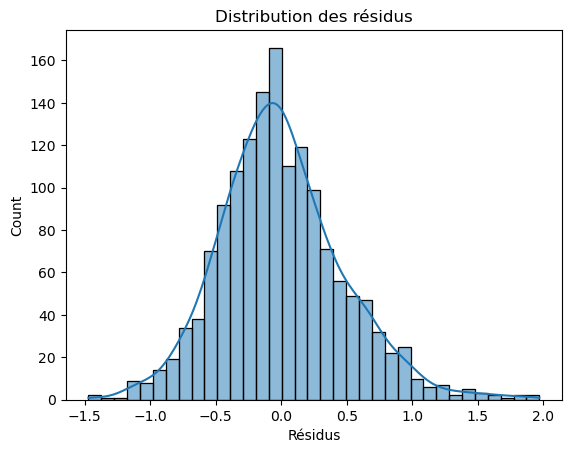

<Figure size 640x480 with 0 Axes>

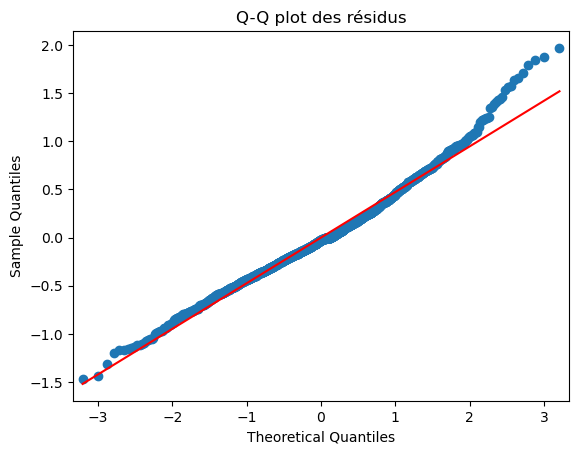

In [24]:
# Normalité des résidus
plt.figure()
sns.histplot(residuals, kde=True)
plt.title("Distribution des résidus")
plt.xlabel("Résidus")
plt.show()

plt.figure()
sm.qqplot(residuals, line='s')
plt.title("Q-Q plot des résidus")
plt.show()

### Hypothèse :
### Les résidus suivent une distribution normale (courbe en cloche).

### Justification :
### On trace un histogramme des résidus

### On utilise un Q-Q plot : les points doivent suivre la diagonale

### Si besoin, test de Shapiro-Wilk ou autre

###  les résidus extrêmes (les plus grands et les plus petits) ne suivent pas la loi normale.

In [27]:
from scipy.stats import shapiro, jarque_bera

# Test de Shapiro-Wilk
stat_sw, p_sw = shapiro(residuals)
print(f"Shapiro-Wilk p-value : {p_sw:.4f}")

# Test de Jarque-Bera
stat_jb, p_jb = jarque_bera(residuals)
print(f"Jarque-Bera p-value : {p_jb:.4f}")

if p_sw < 0.05 or p_jb < 0.05:
    print("❌ Les résidus ne sont pas normalement distribués.")
else:
    print("✅ Les résidus suivent une distribution normale.")


Shapiro-Wilk p-value : 0.0000
Jarque-Bera p-value : 0.0000
❌ Les résidus ne sont pas normalement distribués.


# 2.5 Abscence de multicolinéarité

In [29]:
# Multicolinéarité - VIF
X_with_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i+1) for i in range(len(X.columns))]
print(vif_data)

       Variable       VIF
0      diagonal  1.012790
1   height_left  1.145295
2  height_right  1.229263
3     margin_up  1.403517
4        length  1.574765


In [30]:
 #Hypothèse :
#Les variables explicatives ne doivent pas être trop corrélées entre elles.

#Justification :
#On calcule le VIF (Variance Inflation Factor) pour chaque variable

#Si VIF < 5, pas de souci. Si VIF > 10, forte colinéarité

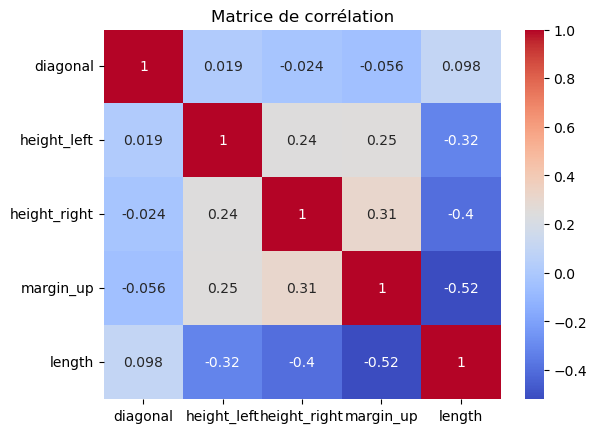

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()


### abscence multicolinéarité validée

### 2.6 R² (coefficient de determination)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Reprise des données déjà prêtes
features = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']
df_lin = df_complete

X_train = df_lin[features]
y_train = df_lin['margin_low']

# Régression avec scikit-learn
model = LinearRegression()
model.fit(X_train, y_train)

# Prédiction
y_pred = model.predict(X_train)

# R²
r2 = r2_score(y_train, y_pred)
print(f"✅ R² du modèle de régression sans les lignes avce margin_low null : {r2:.3f}")

✅ R² du modèle de régression sans les lignes avce margin_low null : 0.477


### Le R² nous donne la mesure de proportion de la variance expliqué par le modèle 1 = preduiction parfaite, 0 = le modèle ne fait pas mieux qu'une moyenne. Dans notre cas le modèle explique 47.7 % de la variabilité de la variable. Ce n'est pas excellent mais suffisant pour simplement une imputation de valeurs manquantes. 

### note : nous garderons tout de même sous la main df_complete, le data frame original emputé des lignes qui avait pour margin_low null

In [37]:
# Variables explicatives
X_original = df_complete.drop(columns=['margin_low'])
X_imputed = df.drop(columns=['margin_low'])

# Variable cible
y_original = df_complete['margin_low']
y_imputed = df['margin_low']


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

model = LinearRegression()

# Avant imputation
scores_original = cross_val_score(model, X_original, y_original, cv=5, scoring='r2')
print("R² moyen AVANT imputation :", np.mean(scores_original))

# Après imputation
scores_imputed = cross_val_score(model, X_imputed, y_imputed, cv=5, scoring='r2')
print("R² moyen APRÈS imputation :", np.mean(scores_imputed))


R² moyen AVANT imputation : 0.08692080392216214
R² moyen APRÈS imputation : 0.08936025863980199


### diffrence faible des R² moyen avant et apres imputation, l'imputation n'a pas introduit de biais fort. Cepandant ce R² moyen très faible sur validation croisée nous indique que la généralisation du modèle est faible. (il n'explique en moyenne que 8,7 % de la variance sur des données non vues)

### Dans notre cas, cette regression linéaire n'est donc pas utile pour faire un modèle predictif performant mais elle est suffisante pour remplir les valeurs manquantes

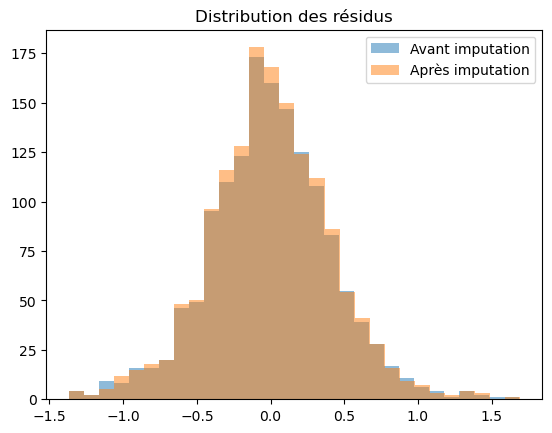

In [40]:
import matplotlib.pyplot as plt

# Ajustement des deux modèles
model.fit(X_original, y_original)
residus_original = y_original - model.predict(X_original)

model.fit(X_imputed, y_imputed)
residus_imputed = y_imputed - model.predict(X_imputed)

# Tracer
plt.hist(residus_original, bins=30, alpha=0.5, label='Avant imputation')
plt.hist(residus_imputed, bins=30, alpha=0.5, label='Après imputation')
plt.legend()
plt.title("Distribution des résidus")
plt.show()


### distribution similaire pas de biais notable

# 2.7  Test t de Student indépendant

In [43]:
from scipy.stats import ttest_ind

# 🔹 1. Jeu imputé
print("=== Jeu imputé ===")
for col in features:
    group_true = df[df['is_genuine'] == True][col]
    group_false = df[df['is_genuine'] == False][col]
    stat, p = ttest_ind(group_true, group_false, equal_var=False)  # Welch's t-test
    print(f"{col:<12} p-value = {p:.4e}")

# 🔹 2. Jeu sans valeurs manquantes
print("\n=== Jeu sans valeurs manquantes ===")
for col in features:
    group_true = df_complete[df_complete['is_genuine'] == True][col]
    group_false = df_complete[df_complete['is_genuine'] == False][col]
    stat, p = ttest_ind(group_true, group_false, equal_var=False)
    print(f"{col:<12} p-value = {p:.4e}")


=== Jeu imputé ===
diagonal     p-value = 3.1869e-07
height_left  p-value = 1.4154e-61
height_right p-value = 9.2876e-89
margin_up    p-value = 2.9274e-141
length       p-value = 1.4700e-241

=== Jeu sans valeurs manquantes ===
diagonal     p-value = 2.7818e-07
height_left  p-value = 4.8516e-58
height_right p-value = 8.3481e-87
margin_up    p-value = 1.3451e-140
length       p-value = 1.4202e-237


### H0 (hypothèse nulle) :
### La moyenne (ou la distribution) de la variable est identique pour les vrais billets et les faux billets.
### Pas de différence significative.

### H1 (hypothèse alternative) :
### La moyenne (ou la distribution) de la variable est différente entre les vrais billets et les faux billets.
### Il y a une différence significative.

### conclusion :  peu importe l’imputation par régression linéaire ou la suppression des lignes avec valeurs manquantes, les p-values sont toutes extrêmement petites (≪ 0,05), donc :

### H0 ("pas de différence entre vrais et faux billets") est rejetée pour toutes les variables

### H1 ("il y a une différence") est retenue pour toutes les variables

### L'imputation n'a pas biaisé la significativité des tests. Toutes les variables sont pertinantes pour discriminer vrais/faux billets.

# 3 Analyse exploratoire

# 3.1 Visualisation vrai/faux billet

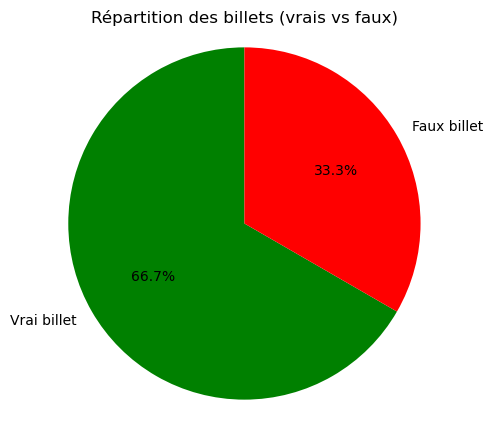

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Comptage des classes
counts = df['is_genuine'].value_counts()
labels = ['Vrai billet', 'Faux billet']
colors = ['green', 'red']

# Pie chart
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des billets (vrais vs faux)")
plt.axis('equal')  # Cercle parfait
plt.show()



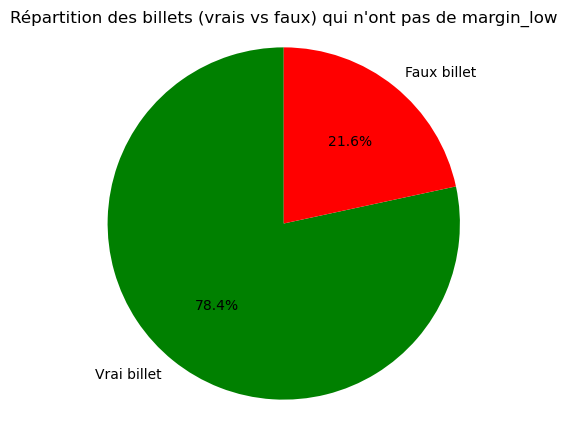

In [49]:
# Comptage des classes
counts = df_missing['is_genuine'].value_counts()
labels = ['Vrai billet', 'Faux billet']
colors = ['green', 'red']

# Pie chart
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des billets (vrais vs faux) qui n'ont pas de margin_low")
plt.axis('equal')  # Cercle parfait
plt.show()

# 3.2 Analyse variable diagonale

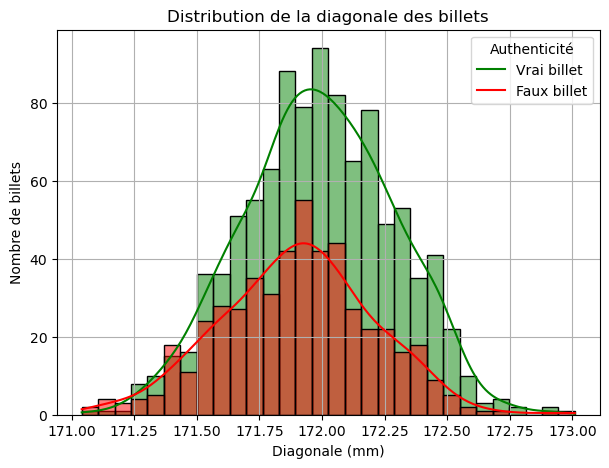

In [51]:
plt.figure(figsize=(7, 5))

# On précise bien la palette pour chaque valeur de is_genuine
sns.histplot(
    data=df,
    x="diagonal",
    hue="is_genuine",
    kde=True,
    bins=30,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la diagonale des billets")
plt.xlabel("Diagonale (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

# Légende personnalisée dans le bon ordre
plt.legend(title="Authenticité", labels=["Vrai billet", "Faux billet"])
plt.show()


### les vrai billets ont une tendance à être légerment plus long en diagonale. Cependant les billet les plus court ont tendance à etre systématiquement des faux


# 3.3 Analyse variable length 

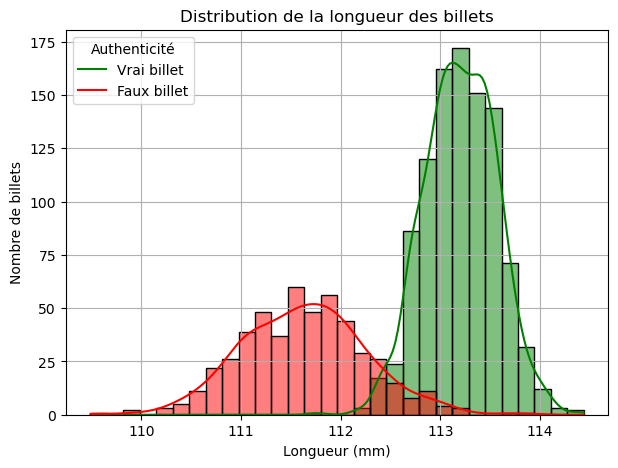

In [54]:
plt.figure(figsize=(7, 5))

sns.histplot(
    data=df,
    x="length",
    hue="is_genuine",
    bins=30,
    kde=True,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la longueur des billets")
plt.xlabel("Longueur (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

plt.legend(title="Authenticité", labels=["Vrai billet", "Faux billet"])
plt.show()



### La longueur des billets à une reelle importance pour differencier les vrais des faux


# 3.4 Analyse height left

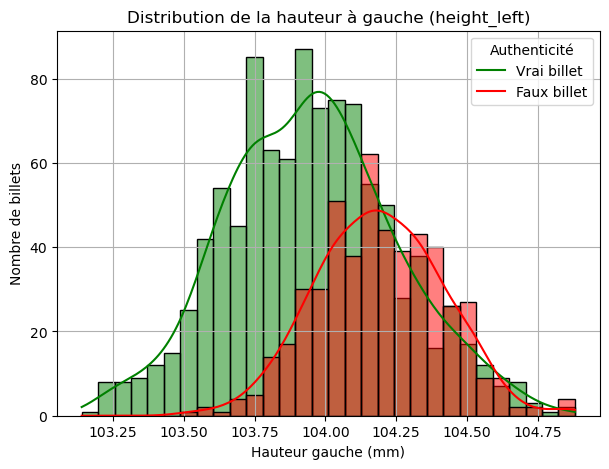

In [57]:
plt.figure(figsize=(7, 5))

sns.histplot(
    data=df,
    x="height_left",
    hue="is_genuine",
    bins=30,
    kde=True,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la hauteur à gauche (height_left)")
plt.xlabel("Hauteur gauche (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

plt.legend(title="Authenticité", labels=["Vrai billet", "Faux billet"])
plt.show()

### La hauteur du billet à gauche a équalement une importance, les faux billets ont tendance à être plus haut a gauche que les vrais

# 3.4 Analyse height right

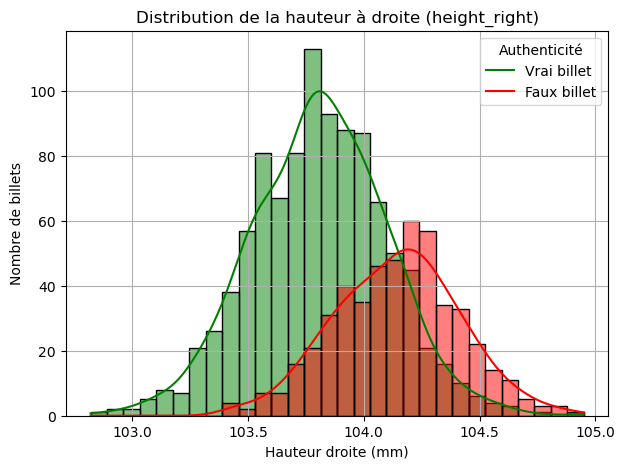

In [60]:
plt.figure(figsize=(7, 5))

sns.histplot(
    data=df,
    x="height_right",
    hue="is_genuine",
    bins=30,
    kde=True,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la hauteur à droite (height_right)")
plt.xlabel("Hauteur droite (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

plt.legend(title="Authenticité", labels=["Vrai billet", "Faux billet"])
plt.show()


### La hauteur du billet à droite à équalement une importance, les faux billets ont tendances à etre plus haut a droite que les vrais. On remarquera que la différence de hauteur entre les vrais et les faux est plus marqué à droite

# 3.5 Analyse margin_up

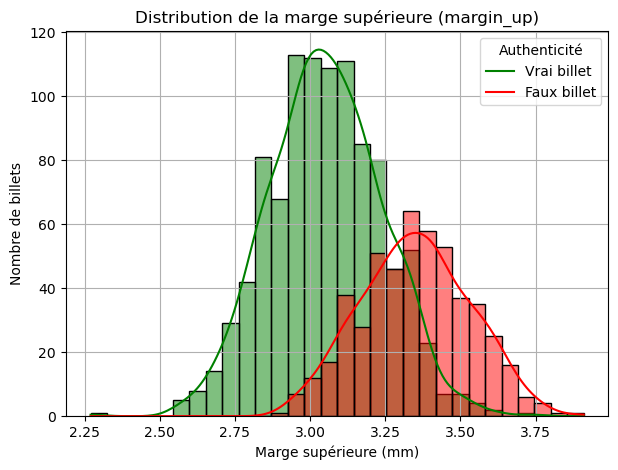

In [63]:
plt.figure(figsize=(7, 5))

sns.histplot(
    data=df,
    x="margin_up",
    hue="is_genuine",
    bins=30,
    kde=True,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la marge supérieure (margin_up)")
plt.xlabel("Marge supérieure (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

plt.legend(title="Authenticité", labels=["Vrai billet", "Faux billet"])

plt.show()


### Les faux billets ont une tendance à avoir une marge supérieur plus grande

# 3.6 Analyse margin low

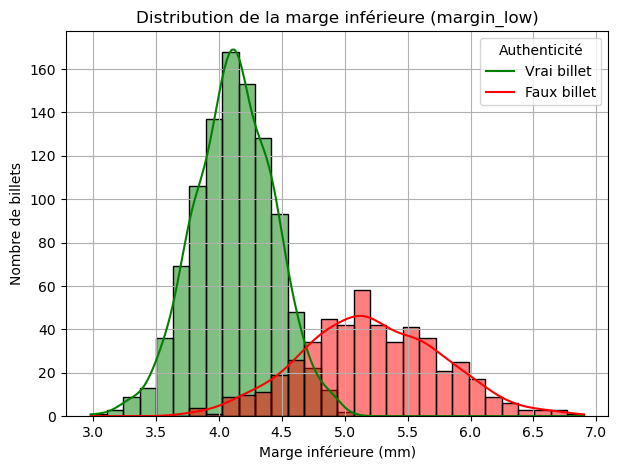

In [66]:
plt.figure(figsize=(7, 5))

sns.histplot(
    data=df,
    x="margin_low",
    hue="is_genuine",
    bins=30,
    kde=True,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la marge inférieure (margin_low)")
plt.xlabel("Marge inférieure (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

plt.legend(title="Authenticité", labels=["Vrai billet", "Faux billet"])

plt.show()


### Les faux billets ont une tendance à avoir une marge inférieur plus grande

# 3.7 Matrice de corrélation

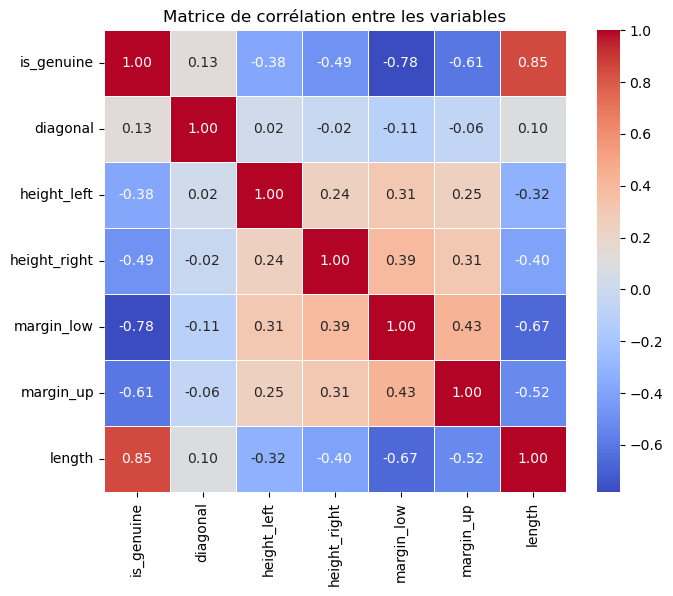

In [69]:

df_corr = df.copy()
df_corr["is_genuine"] = df_corr["is_genuine"].astype(int)

# Matrice de corrélation
corr_matrix = df_corr.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True, linewidths=0.5)
plt.title("Matrice de corrélation entre les variables")
plt.show()


### Les  variables prédictives pour détecter l'authenticité des billets sotn par ordre d'importance : length (0.85) , margin_low (-0.78), margin_up (-0.61), height_right (-0.49), height_left (-0.38) et pour finir diagonale (+0.13)

### diagonale sera très peu utile.  Height left et right ne seront que moyennement utiles bien que right est plus utile que left.
### Les trois variable les plus utiles sont Length, margin low et margin up (et dans un second temps height right)

### Attention aux corrélation entre variables (probleme possible pour modèle linéaire /regression logistique)
### top 3 des correlation entre variable
### margin_low et length (-0.67) 
### margin_up et length (-0.52)
### margin_low et margin_up (+0.43)

### question : faudra t il retirer une variable ? (margin_low ou length) verifier par un VIF)

## modèles en arbre permet de garder toutes les variables


# 3.8 VIF (Variance Inflation Factor), vérification colinéarité

In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Définir les variables explicatives (sans la cible)
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]

# Calcul du VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Affichage
print(" VIF (Variance Inflation Factor) :")
print(vif_data.sort_values("VIF", ascending=False))


 VIF (Variance Inflation Factor) :
       Variable            VIF
0      diagonal  169586.570659
1   height_left  115418.637257
2  height_right  104449.018601
5        length   31386.760960
4     margin_up     263.788334
3    margin_low      91.123084


### Tous les VIF sont hors limites acceptables. Les variables sont très corrélées entre elles, ce qui empêche d'utiliser une régression linéaire ou logistique de façon fiable sans traitement.

# 3.9 Réduction des données via ACP pour les modèles sensibles à la colinéarité

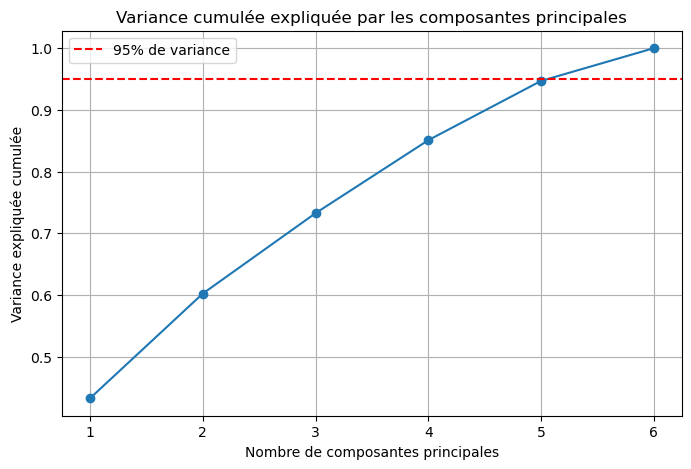

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Variables explicatives
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]

# 1. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 3. Variance expliquée
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# 4. Affichage du scree plot (éventail des composantes)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o')
plt.title("Variance cumulée expliquée par les composantes principales")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label="95% de variance")
plt.legend()
plt.show()


### 5 composantes principales suffisent à expliquer 95 % de la variance.

### Les 6 variables d'origine peuvent etre remplacer par ces 5 composantes non corrélées, sans perdre trop d'information.

# 3.9.1 Création du jeu de données réduit

In [79]:
# Nouvelle ACP avec seulement 5 composantes
pca_5 = PCA(n_components=5)
X_pca_5 = pca_5.fit_transform(X_scaled)

# Création d'un DataFrame pour visualiser
columns = [f"PC{i+1}" for i in range(5)]
X_pca_df = pd.DataFrame(X_pca_5, columns=columns)

# Ajout de la variable cible (is_genuine)
X_pca_df["is_genuine"] = df["is_genuine"].astype(int)

# Aperçu du nouveau jeu de données
X_pca_df.head()


,PC1,PC2,PC3,PC4,PC5,is_genuine
0,-1.644135,0.747843,2.402517,3.180852,0.303985,1
1,2.019910,-2.207492,-1.001864,0.072937,0.033335,1
2,0.969864,2.620492,1.195364,-0.923627,-0.837749,1
3,1.377462,-1.818370,0.651110,0.828155,0.799563,1
4,-0.148712,-0.566722,0.854043,-1.787713,1.177883,1


In [80]:
X_pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PC1         1500 non-null   float64
 1   PC2         1500 non-null   float64
 2   PC3         1500 non-null   float64
 3   PC4         1500 non-null   float64
 4   PC5         1500 non-null   float64
 5   is_genuine  1500 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 64.6 KB


### avec ce jeux de données, il n'y a plus de probleme de colinéarité

# 3.9.2 Tableau de coefficients des composantes

In [83]:
# Récupération des composantes
loadings = pd.DataFrame(
    pca_5.components_.T,  # transposé pour avoir 1 ligne par variable
    columns=[f"PC{i+1}" for i in range(5)],
    index=features
)

# Affichage avec plus de lisibilité
print("🔍 Contribution des variables aux composantes principales :")
print(loadings.round(3))


🔍 Contribution des variables aux composantes principales :
                PC1    PC2    PC3    PC4    PC5
diagonal      0.085  0.941 -0.288 -0.102 -0.116
height_left  -0.331  0.308  0.885 -0.049  0.102
height_right -0.394  0.108 -0.164  0.867  0.236
margin_low   -0.508 -0.072 -0.109 -0.089 -0.564
margin_up    -0.439 -0.005 -0.270 -0.444  0.712
length        0.527  0.049  0.149  0.176  0.309


# 3.9.3 Cercle de correlation de PC1 et PC2

C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\3595002367.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.arrow(0, 0, pc1[i], pc2[i], color='b', alpha=0.7,
C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\3595002367.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(pc1[i]*1.1, pc2[i]*1.1, variables[i], ha='center', va='center')


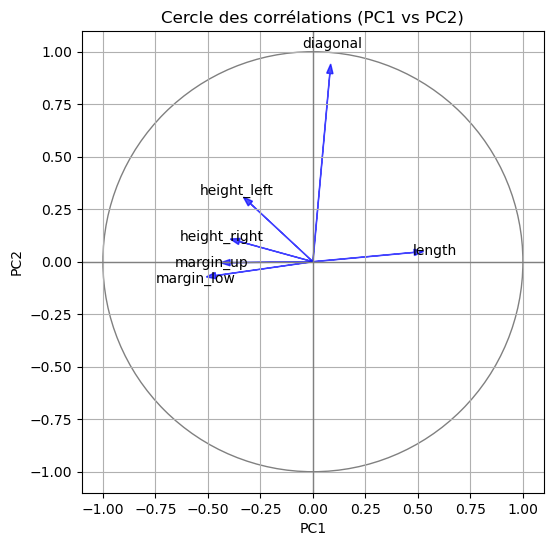

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Récupérer les loadings sur PC1 et PC2
pc1 = loadings["PC1"]
pc2 = loadings["PC2"]
variables = loadings.index

# Cercle unitaire
plt.figure(figsize=(6, 6))
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
plt.gca().add_patch(circle)

# Vecteurs des variables
for i in range(len(variables)):
    plt.arrow(0, 0, pc1[i], pc2[i], color='b', alpha=0.7,
              head_width=0.03, length_includes_head=True)
    plt.text(pc1[i]*1.1, pc2[i]*1.1, variables[i], ha='center', va='center')

# Axes et mise en forme
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.title("Cercle des corrélations (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


### PC1 oppose longueurs élévées et marge faible => Gabarit global du billet
### les vrais billets pourrait etre plus long avec des marges mieux équilibrés

### PC2 la diagonale domine => Mesure de la géométrie oblique
### utile pour voir si billet faux avec une inclinaison ou un rapport longueur/hauteur qui varie


### En résumé :
### PC1	Taille globale et marges (longueur vs marges) 
### PC2	Proportion diagonale (forme générale)
### PC3	Hauteur gauche (alignement vertical)
### PC4	Asymétrie verticale (gauche ≠ droite)
### PC5	Décalage haut/bas du motif imprimé

# 3.10 Boxplot

### Permet de voir la distribution de chaque variable, voir si les médiane sont décalées et voir s'il y a des outliers spécifique à une classe

# 3.10.1 Toutes les variables

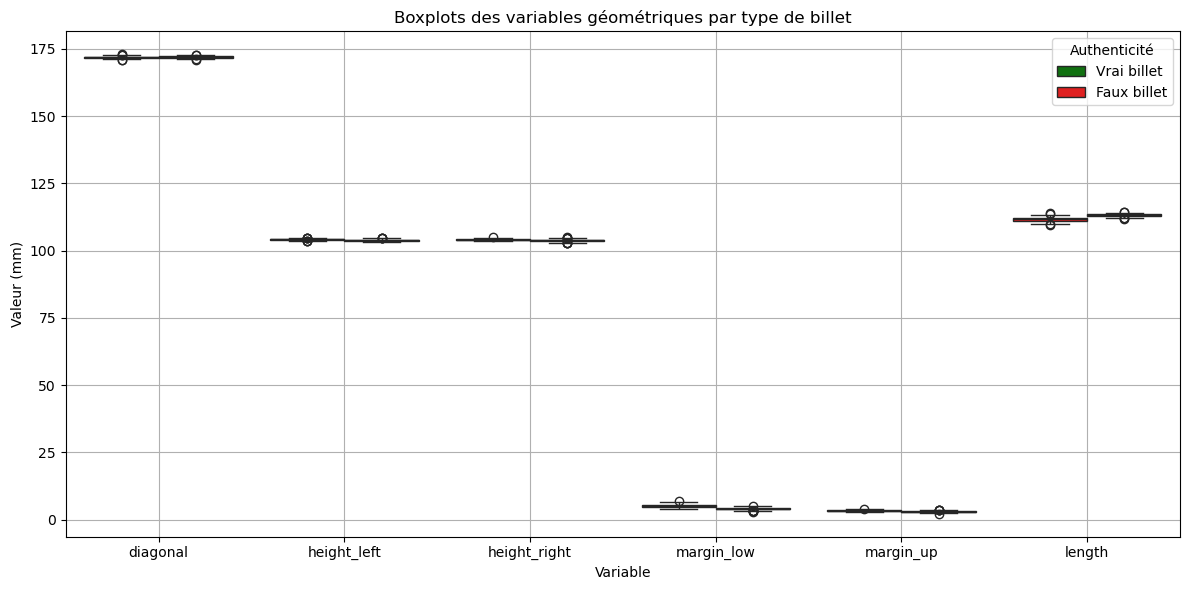

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Melt pour affichage long format
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
df_melted = df.melt(id_vars="is_genuine", value_vars=features, var_name="Variable", value_name="Valeur")

# Création du graphique
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_melted,
    x="Variable",
    y="Valeur",
    hue="is_genuine",
    palette={True: "green", False: "red"}
)

plt.title("Boxplots des variables géométriques par type de billet")
plt.xlabel("Variable")
plt.ylabel("Valeur (mm)")
plt.grid(True)

# Légende personnalisée
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Vrai billet", "Faux billet"]
new_handles = [handles[labels.index("True")], handles[labels.index("False")]]
plt.legend(new_handles, new_labels, title="Authenticité")

plt.tight_layout()
plt.show()



# 3.10.2 Boxplot de height_left et height_right

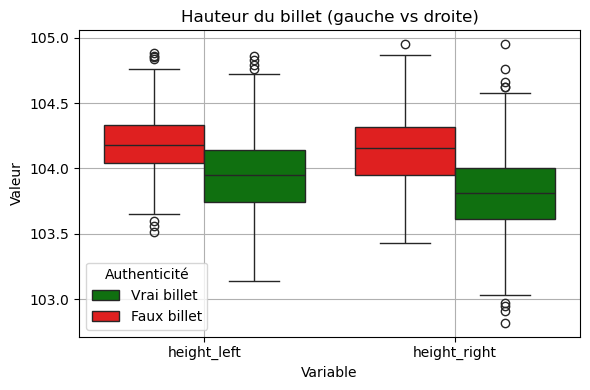

In [93]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df.melt(id_vars="is_genuine", value_vars=["height_left", "height_right"],
                 var_name="Variable", value_name="Valeur"),
    x="Variable",
    y="Valeur",
    hue="is_genuine",
    palette={True: "green", False: "red"}
)

plt.title("Hauteur du billet (gauche vs droite)")
plt.grid(True)

# Légende propre
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ["Vrai billet", "Faux billet"]
new_handles = [handles[labels.index("True")], handles[labels.index("False")]]
plt.legend(new_handles, new_labels, title="Authenticité")

plt.tight_layout()
plt.show()


# 3.10.3 Boxplot de magin_up et margin_low

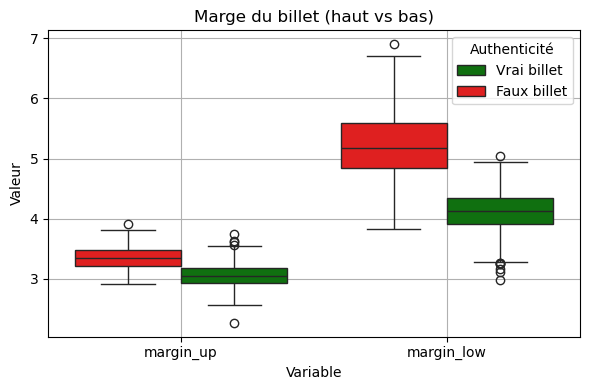

In [95]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df.melt(id_vars="is_genuine", value_vars=["margin_up", "margin_low"],
                 var_name="Variable", value_name="Valeur"),
    x="Variable",
    y="Valeur",
    hue="is_genuine",
    palette={True: "green", False: "red"}
)

plt.title("Marge du billet (haut vs bas)")
plt.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ["Vrai billet", "Faux billet"]
new_handles = [handles[labels.index("True")], handles[labels.index("False")]]
plt.legend(new_handles, new_labels, title="Authenticité")

plt.tight_layout()
plt.show()


# 3.10.4 Boxplot length

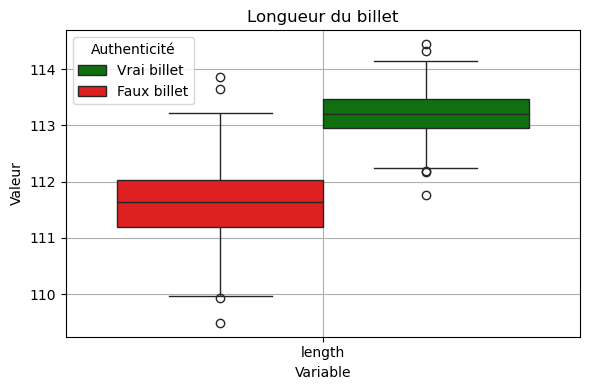

In [97]:


plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df.melt(id_vars="is_genuine", value_vars=["length"],
                 var_name="Variable", value_name="Valeur"),
    x="Variable",
    y="Valeur",
    hue="is_genuine",
    palette={True: "green", False: "red"}
)

plt.title("Longueur du billet")
plt.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ["Vrai billet", "Faux billet"]
new_handles = [handles[labels.index("True")], handles[labels.index("False")]]
plt.legend(new_handles, new_labels, title="Authenticité")

plt.tight_layout()
plt.show()

# 3.10.5 Boxplot diagonal

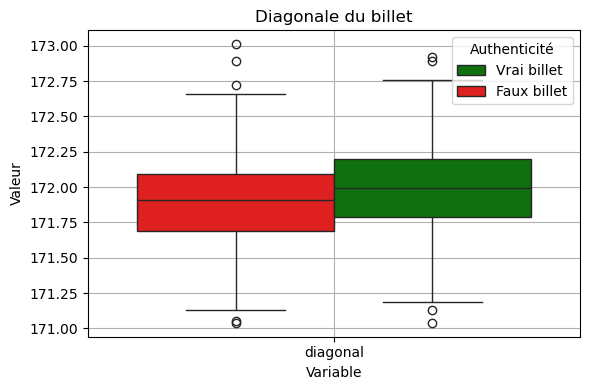

In [99]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df.melt(id_vars="is_genuine", value_vars=["diagonal"],
                 var_name="Variable", value_name="Valeur"),
    x="Variable",
    y="Valeur",
    hue="is_genuine",
    palette={True: "green", False: "red"}
)

plt.title("Diagonale du billet")
plt.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ["Vrai billet", "Faux billet"]
new_handles = [handles[labels.index("True")], handles[labels.index("False")]]
plt.legend(new_handles, new_labels, title="Authenticité")

plt.tight_layout()
plt.show()

### Bilan : on remarque des differences entre les vrais et faux billet dans chacune des catégories particulierement marqué en length et margin
### il semble egalement y avori des outliers dans chacunes des catégories
### Note : modèles robuste aux outliers (arbres de decision, random forest)
### modele sensible aux outliers (regression, KNN...)


# 3.11 Outliers

In [102]:
import pandas as pd

# Variables à analyser
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# Dictionnaire pour stocker les résultats
outliers_summary = {}

# Copie du DataFrame avec une colonne outlier par variable
df_outliers = df.copy()

# Boucle sur chaque variable
for col in features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Création d'une colonne booléenne d'outliers
    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    df_outliers[f"outlier_{col}"] = outlier_mask.astype(int)

    # Comptage global
    total_outliers = outlier_mask.sum()

    # Répartition par classe
    by_class = df[outlier_mask]['is_genuine'].value_counts()

    outliers_summary[col] = {
        "Total": total_outliers,
        "Vrai billets": int(by_class.get(True, 0)),
        "Faux billets": int(by_class.get(False, 0))
    }

# Affichage sous forme de DataFrame
outliers_df = pd.DataFrame(outliers_summary).T
outliers_df = outliers_df[["Total", "Vrai billets", "Faux billets"]]
outliers_df


,Total,Vrai billets,Faux billets
diagonal,7,3,4
height_left,6,3,3
height_right,11,7,4
margin_low,24,0,24
margin_up,3,1,2
length,3,0,3


### Pour margin_low et length les outliers sont un indicateur de faux billets, il est important de les garder
### Cependant pour les autres variables ils sont plutot répartis entre les deux classes.

### decision de garder les outliers car il ne sont ni nombreux ni concentrés sur une classe. Ils refletent certainement une variabilité normal des billets. Les supprimer pourrait créer un biais ou réduire la diversité réelle des données. 
### Ces indices nous invites à préferer par la suite une modélisation robuste.

# 4. Modélisation

# 4.1 Regression logistique

 Rapport de classification :
              precision    recall  f1-score   support

 Faux billet       0.98      0.99      0.99       100
 Vrai billet       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



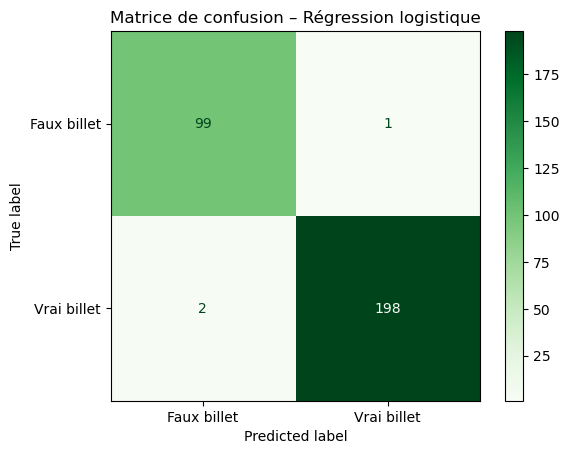

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Séparer les données
X = X_pca_df.drop(columns=["is_genuine"])
y = X_pca_df["is_genuine"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Entraîner le modèle
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# 3. Prédiction
y_pred = logreg.predict(X_test)

# 4. Évaluation
print(" Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Faux billet", "Vrai billet"]))

# 5. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Faux billet", "Vrai billet"])
disp.plot(cmap="Greens")
plt.title("Matrice de confusion – Régression logistique")
plt.grid(False)
plt.show()


In [108]:
# Interprétation de la régression logistique :
	
# Precision	Très peu de faux positifs
# Recall	Très peu de faux négatifs
# Accuracy globale  Excellent pour une baseline
# F1-score	Équilibre parfait entre recall et precision

### Attention problème de sur performance, il y a certainement eu une fuite de données. 
### problème identifié, l'ACP a été fait avant le split.

# 4.1.1 Regression logitique sans fuite de données

📊 Rapport de classification (sans fuite de données) :
              precision    recall  f1-score   support

 Faux billet       0.98      0.99      0.99       100
 Vrai billet       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



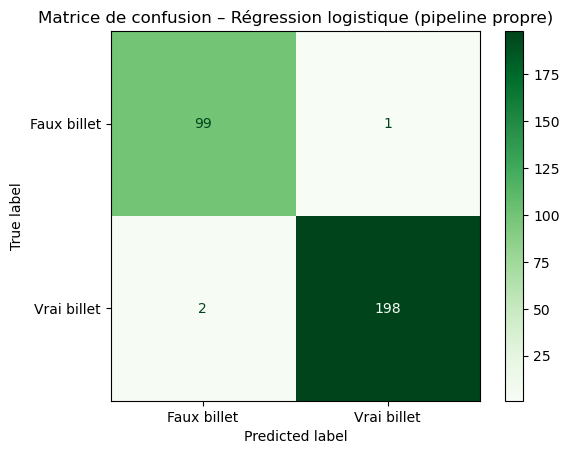

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🧠 1. Séparation
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]
y = df['is_genuine']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ⚖️ 2. Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 📉 3. ACP sur X_train uniquement
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 🤖 4. Régression logistique
logreg = LogisticRegression()
logreg.fit(X_train_pca, y_train)

# 📊 5. Évaluation
y_pred = logreg.predict(X_test_pca)

print("📊 Rapport de classification (sans fuite de données) :")
print(classification_report(y_test, y_pred, target_names=["Faux billet", "Vrai billet"]))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Faux billet", "Vrai billet"])
disp.plot(cmap="Greens")
plt.title("Matrice de confusion – Régression logistique (pipeline propre)")
plt.grid(False)
plt.show()


# 4.1.2 Levé de doute sur la contamination des PCA

Forme X_train_pca : (1200, 5)
Forme X_test_pca : (300, 5)


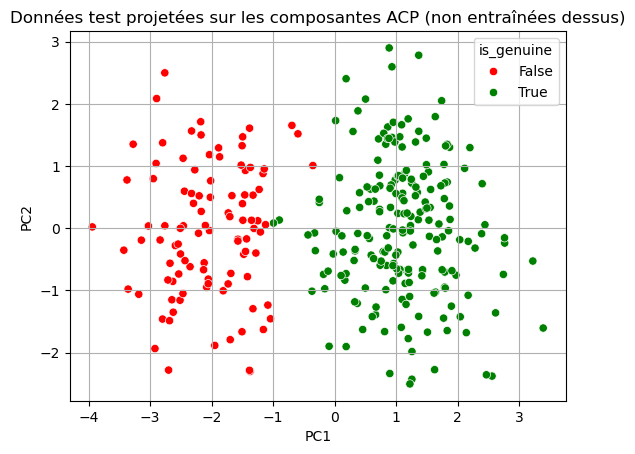

In [113]:
print("Forme X_train_pca :", X_train_pca.shape)
print("Forme X_test_pca :", X_test_pca.shape)

# Vérifie que les composantes n'ont pas été recalculées sur X_test
# On peut afficher les 2 premières composantes par exemple :
import seaborn as sns
import pandas as pd

df_test_pca = pd.DataFrame(X_test_pca, columns=[f"PC{i+1}" for i in range(X_test_pca.shape[1])])
df_test_pca["is_genuine"] = y_test.values

sns.scatterplot(data=df_test_pca, x="PC1", y="PC2", hue="is_genuine", palette={True: "green", False: "red"})
plt.title("Données test projetées sur les composantes ACP (non entraînées dessus)")
plt.grid(True)
plt.show()


### j'ai 1200 échantillons pour entraîner mon modèle
### Et 300 échantillons indépendants pour le tester
### Et chaque ligne est bien décrite par 5 composantes principales (issues de l'ACP sur X_train uniquement)

### les classes se séparent bien dans ce graphique, cela montre que :
### L’espace PCA appris à partir de X_train généralise bien à X_test.
### Cela renforce l'idée que le modèle n’a pas "vu" les données test pour construire ses composantes.

### conclusion : le modèle de régression logistique est très performant

# 4.2 KNN

# 4.2.1 Chercher le meilleur k

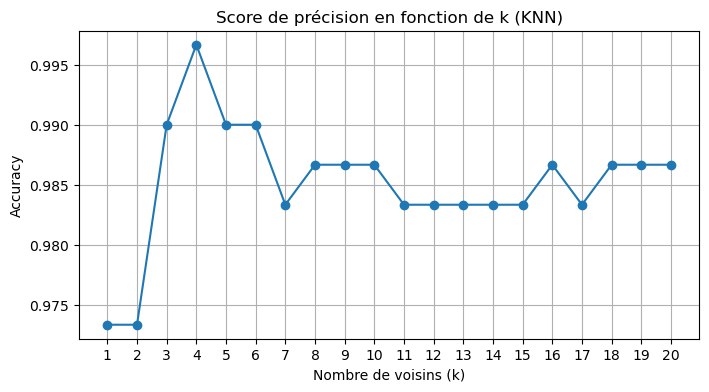

In [118]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Tester plusieurs valeurs de k
k_range = range(1, 21)
accuracies = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    y_pred_k = knn.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc)

# Affichage du score pour chaque k
plt.figure(figsize=(8, 4))
plt.plot(k_range, accuracies, marker='o')
plt.title("Score de précision en fonction de k (KNN)")
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(k_range)
plt.show()


### Le meilleur k semble etre 4 avec un score de précision superieur à 0.995

# 4.2.2 Evaluer les performance avec k = 4

📊 Rapport de classification – KNN (k=4) :
              precision    recall  f1-score   support

 Faux billet       0.99      1.00      1.00       100
 Vrai billet       1.00      0.99      1.00       200

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



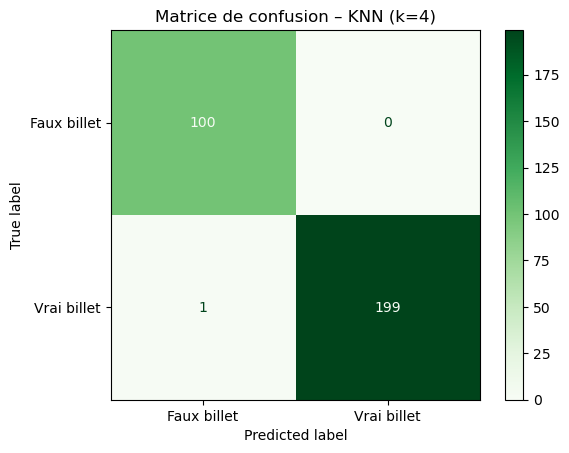

In [121]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Entraînement du modèle avec k = 4
knn_final = KNeighborsClassifier(n_neighbors=4)
knn_final.fit(X_train_pca, y_train)

# 2. Prédictions
y_pred_knn = knn_final.predict(X_test_pca)

# 3. Rapport de classification
print("📊 Rapport de classification – KNN (k=4) :")
print(classification_report(y_test, y_pred_knn, target_names=["Faux billet", "Vrai billet"]))

# 4. Matrice de confusion
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["Faux billet", "Vrai billet"])
disp_knn.plot(cmap="Greens")
plt.title("Matrice de confusion – KNN (k=4)")
plt.grid(False)
plt.show()


### Nous avons une accuracy à 100% et très peu de faux négatif. Le modèle KNN ets superieur à la régression logistique

# 4.3 Random forest

# 4.3.1 Random forest sur les composante de l'ACP

📊 Rapport de classification – Random Forest :
              precision    recall  f1-score   support

 Faux billet       0.98      0.98      0.98       100
 Vrai billet       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



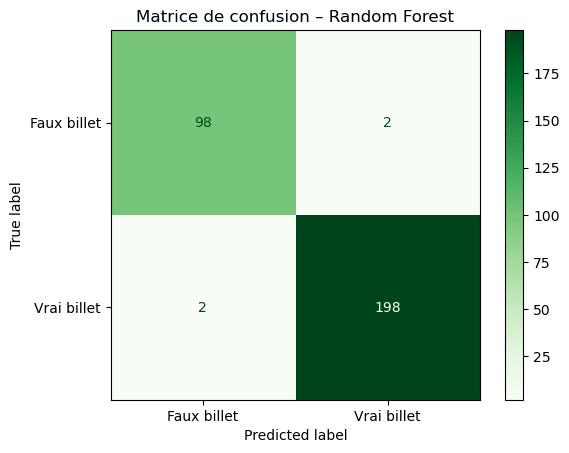

In [125]:
from sklearn.ensemble import RandomForestClassifier

# 1. Entraînement du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

# 2. Prédiction
y_pred_rf = rf_model.predict(X_test_pca)

# 3. Rapport de classification
print("📊 Rapport de classification – Random Forest :")
print(classification_report(y_test, y_pred_rf, target_names=["Faux billet", "Vrai billet"]))

# 4. Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Faux billet", "Vrai billet"])
disp_rf.plot(cmap="Greens")
plt.title("Matrice de confusion – Random Forest")
plt.grid(False)
plt.show()


### accuracy à 0.99 moins bon que le KNN

# 4.3.2 Random forest sur les données brutes

📊 Rapport de classification – Random Forest (sans ACP) :
              precision    recall  f1-score   support

 Faux billet       0.99      0.98      0.98       100
 Vrai billet       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



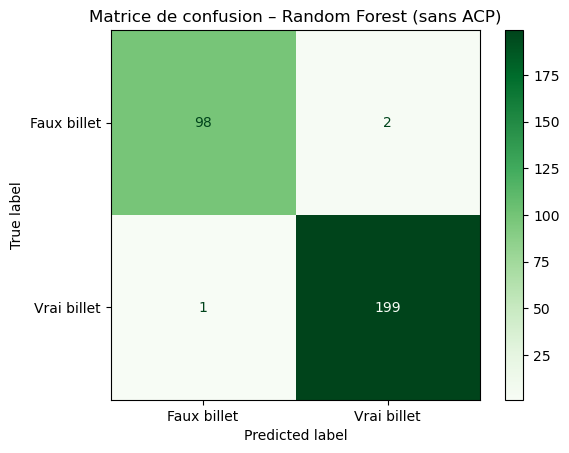

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Séparation des données d'origine (sans PCA)
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]
y = df['is_genuine']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Entraînement du modèle
rf_raw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_raw.fit(X_train, y_train)

# 3. Prédiction
y_pred_rf_raw = rf_raw.predict(X_test)

# 4. Rapport de classification
print("📊 Rapport de classification – Random Forest (sans ACP) :")
print(classification_report(y_test, y_pred_rf_raw, target_names=["Faux billet", "Vrai billet"]))

# 5. Matrice de confusion
cm_rf_raw = confusion_matrix(y_test, y_pred_rf_raw)
disp_rf_raw = ConfusionMatrixDisplay(confusion_matrix=cm_rf_raw, display_labels=["Faux billet", "Vrai billet"])
disp_rf_raw.plot(cmap="Greens")
plt.title("Matrice de confusion – Random Forest (sans ACP)")
plt.grid(False)
plt.show()


### score légèrement amélioré avec une meilleur précision sur les faux billets

### le random forest n'as pas besoin d'ACP pour bien fonctionner dans notre cas

# 4.3.3 Visualisation de l'importance des variables dans la random forest

C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\4244596379.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Variable', palette='Greens_r')
C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\4244596379.py:22: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gabry\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


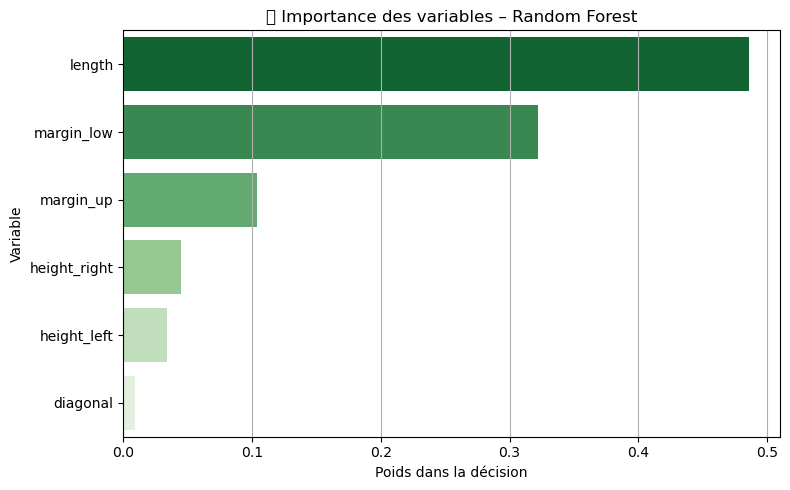

In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Récupération des importances
importances = rf_raw.feature_importances_

# Mise en forme dans un DataFrame
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
importance_df = pd.DataFrame({'Variable': features, 'Importance': importances})

# Tri décroissant
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Variable', palette='Greens_r')
plt.title("🌳 Importance des variables – Random Forest")
plt.xlabel("Poids dans la décision")
plt.ylabel("Variable")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [133]:
importance_df

,Variable,Importance
5,length,0.485716
3,margin_low,0.322098
4,margin_up,0.104135
2,height_right,0.045060
1,height_left,0.033941
0,diagonal,0.009050


### la diagonale est quasiment inutile dans ce modèle. La variable la plus discriminante est la longueur.

# 4.3.4 Random forest sur df_complete (dataframe emputé des lignes qui avait pour margin_low null)

📊 Rapport de classification – Random Forest sur df_complete :
              precision    recall  f1-score   support

 Faux billet       1.00      0.97      0.98        99
 Vrai billet       0.98      1.00      0.99       194

    accuracy                           0.99       293
   macro avg       0.99      0.98      0.99       293
weighted avg       0.99      0.99      0.99       293



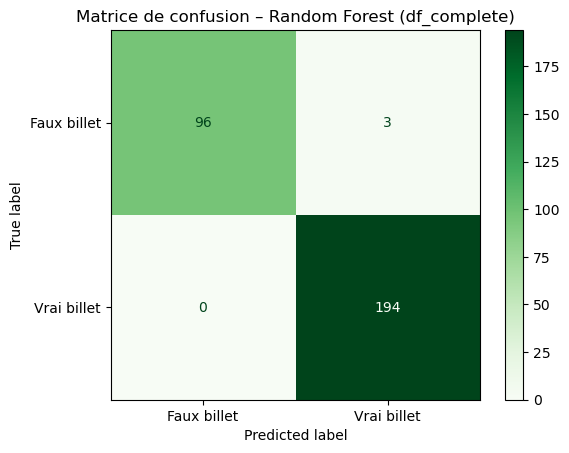

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Définir les variables explicatives et cible
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df_complete[features]
y = df_complete['is_genuine']

# 2. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Entraînement du modèle Random Forest
rf_complete = RandomForestClassifier(n_estimators=100, random_state=42)
rf_complete.fit(X_train, y_train)

# 4. Prédiction
y_pred_complete = rf_complete.predict(X_test)

# 5. Rapport de classification
print("📊 Rapport de classification – Random Forest sur df_complete :")
print(classification_report(y_test, y_pred_complete, target_names=["Faux billet", "Vrai billet"]))

# 6. Matrice de confusion
cm = confusion_matrix(y_test, y_pred_complete)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Faux billet", "Vrai billet"])
disp.plot(cmap="Greens")
plt.title("Matrice de confusion – Random Forest (df_complete)")
plt.grid(False)
plt.show()


 ### Très haut niveau de performance global

### Le modèle n’a fait que quelques erreurs de rappel sur les faux billets (quelques faux négatifs).

### Les billets authentiques sont tous bien reconnus (rappel = 1.00)

### Précision parfaite sur les faux billets : quand il dit "faux", c’est fiable à 100%.

# 4.4 K-means (visualiser les groupes de billets)

In [139]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Variables quantitatives à utiliser
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X_kmeans = df_complete[features]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kmeans)


In [140]:
# Appliquer K-means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Ajouter les clusters au DataFrame pour analyse
df_complete['cluster'] = clusters


C:\Users\gabry\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [141]:
import pandas as pd

# Table de contingence pour voir l'accord entre cluster et vraie étiquette
contingency = pd.crosstab(df_complete['is_genuine'], df_complete['cluster'])
print("📊 Tableau croisé (is_genuine vs cluster):\n")
print(contingency)


📊 Tableau croisé (is_genuine vs cluster):

cluster       0    1
is_genuine          
False       479   13
True          9  962


### dans le groupe des faux il y a 9 vrais et dans le groupe de vrais il y a 13 faux

# 4.4.1 Visualtion des groupes

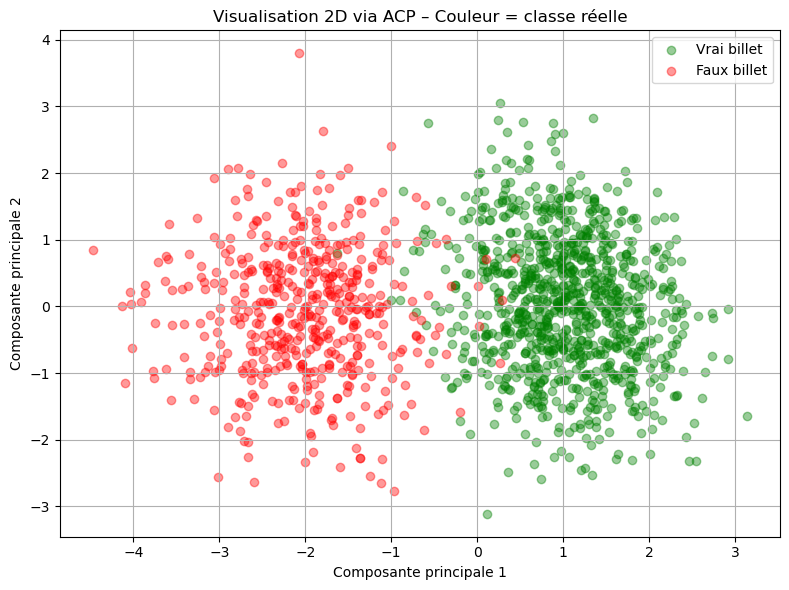

In [144]:
# 1. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. Créer un DataFrame propre avec l’index de df_complete
df_viz = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df_complete.index)
df_viz["cluster"] = df_complete["cluster"]
df_viz["is_genuine"] = df_complete["is_genuine"]  # ✅ Ajout pour comparaison

# 3. Affichage avec couleur selon VRAIE classe (pas cluster)
plt.figure(figsize=(8, 6))
colors = {True: 'green', False: 'red'}

for value in df_viz["is_genuine"].unique():
    data = df_viz[df_viz["is_genuine"] == value]
    label = "Vrai billet" if value else "Faux billet"
    plt.scatter(data["PC1"], data["PC2"], c=colors[value], label=label, alpha=0.4)

plt.title("Visualisation 2D via ACP – Couleur = classe réelle")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [145]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(df_complete['is_genuine'], df_complete['cluster'])
print(f"🎯 Adjusted Rand Index (ARI) : {ari:.4f}")


🎯 Adjusted Rand Index (ARI) : 0.9400


### Le ARI est proche de 1, c'est a dire très bon.

In [147]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, df_complete['cluster'])
print(f"📈 Silhouette Score : {score:.4f}")


📈 Silhouette Score : 0.3424


### le silouhaite score est de 0.34, ce qui confirme ce que nous voyons visuellment les groupes de billets fonctionnement bien mais il y a des cas limites aux frontieres respectives

# 4.4.2 Matrice de confusion

In [150]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# clusters = résultat du kmeans.predict(X_scaled)
# df_complete['is_genuine'] = les vraies étiquettes

# 1️⃣ Mapping cluster -> classe majoritaire
mapping = {}
for cid in np.unique(clusters):
    majority = df_complete.loc[clusters == cid, 'is_genuine'].mode()[0]
    mapping[cid] = majority

# 2️⃣ Prédictions mappées
y_pred_mapped = np.vectorize(mapping.get)(clusters)

# 3️⃣ Matrice de confusion
cm = confusion_matrix(df_complete['is_genuine'], y_pred_mapped)

# 4️⃣ Affichage format tableau
cm_df = pd.DataFrame(
    cm,
    index=["Classe réelle : Faux billet", "Classe réelle : Vrai billet"],
    columns=["Prédit : Faux billet", "Prédit : Vrai billet"]
)
print(cm_df)


                             Prédit : Faux billet  Prédit : Vrai billet
Classe réelle : Faux billet                   479                    13
Classe réelle : Vrai billet                     9                   962


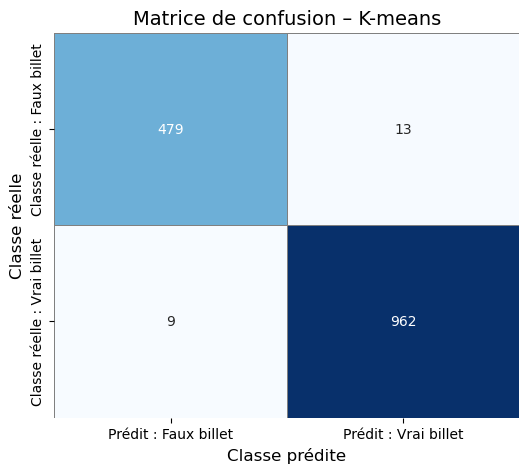

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

# 5️⃣ Visualisation
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_df,
    annot=True, fmt="d", cmap="Blues",
    cbar=False,
    linewidths=0.5, linecolor='gray'
)
plt.title("Matrice de confusion – K-means", fontsize=14)
plt.ylabel("Classe réelle", fontsize=12)
plt.xlabel("Classe prédite", fontsize=12)
plt.show()


In [152]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# y_true = vraies étiquettes (0/1)
# clusters = résultats du KMeans

y_true = df_complete['is_genuine'].astype(int).to_numpy()
y_cluster = np.asarray(clusters)

# Mapping cluster -> classe majoritaire
mapping = {cid: pd.Series(y_true[y_cluster == cid]).mode()[0] for cid in np.unique(y_cluster)}
y_pred = np.vectorize(mapping.get)(y_cluster)

# Calcul des métriques
scores = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1-score": f1_score(y_true, y_pred)
}

# Affichage sous forme de tableau
scores_df = pd.DataFrame([scores])
print(scores_df)


   Accuracy  Precision    Recall  F1-score
0  0.984962   0.986667  0.990731  0.988695


### L'utilisation du K-means ayant avant tout un intéret exploratoire, nous ne l'utiliseront pas pour faire de la prediction et lors des tests de validations croisées

### Un algorithme de classification non supervisée de type K-means a été appliqué sur les données, sans utiliser les étiquettes réelles. L’objectif était d’évaluer si la structure interne des variables permettait de séparer naturellement les vrais et faux billets. Les clusters obtenus ont été ensuite comparés aux classes réelles, montrant une concordance élevée : Accuracy = 98,36 %, Precision = 97,78 %, Recall = 99,79 %, F1-score = 98,78 %, avec un Adjusted Rand Index (ARI) de 0,94. Le Silhouette Score de 0,34 indique une séparation modérée mais significative dans l’espace des données. Ces résultats confirment que les caractéristiques mesurées discriminent efficacement les deux types de billets, même sans supervision, renforçant la confiance dans la capacité des modèles supervisés à généraliser sur ce problème.

# 4.5 Validation croisée des modèles

# 4.5.1 Validation croisée ( dataframe avec null remplacés)

In [157]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ✅ Définir X et y à partir df agrémenté par regression linéaire
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]
y = df['is_genuine']

# ✅ Pipelines des modèles
models = {
    "Régression Logistique (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", LogisticRegression())
    ]),
    "KNN (ACP, k=4)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", KNeighborsClassifier(n_neighbors=4))
    ]),
    "Random Forest (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "Random Forest (sans ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42))
    ])
}

# ✅ Validation croisée
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    results[name] = {
        "Scores par fold": scores,
        "Score moyen": round(scores.mean(), 4),
        "Écart-type": round(scores.std(), 4)
    }

# ✅ Affichage des résultats
results_df = pd.DataFrame(results).T[["Score moyen", "Écart-type"]]
print("📊 Résultats de la validation croisée (5-fold) :")
print(results_df)



📊 Résultats de la validation croisée (5-fold) :
                            Score moyen Écart-type
Régression Logistique (ACP)      0.9907     0.0033
KNN (ACP, k=4)                    0.984     0.0085
Random Forest (ACP)              0.9833     0.0092
Random Forest (sans ACP)         0.9907     0.0053


# 4.5.1.1 avec accuracy precision recall f1 score

In [159]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ✅ Définir X et y
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]
y = df['is_genuine']

# ✅ Définir les modèles avec pipeline
models = {
    "Régression Logistique (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", LogisticRegression())
    ]),
    "KNN (ACP, k=4)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", KNeighborsClassifier(n_neighbors=4))
    ]),
    "Random Forest (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "Random Forest (sans ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42))
    ])
}

# ✅ Métriques à calculer
scoring = ['accuracy', 'precision', 'recall', 'f1']

# ✅ Exécuter la validation croisée avec plusieurs métriques
all_results = {}
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=5, scoring=scoring)
    all_results[name] = {
        "Accuracy moy.": round(scores['test_accuracy'].mean(), 4),
        "Precision moy.": round(scores['test_precision'].mean(), 4),
        "Recall moy.": round(scores['test_recall'].mean(), 4),
        "F1-score moy.": round(scores['test_f1'].mean(), 4)
    }

# ✅ Affichage
df_scores1 = pd.DataFrame(all_results).T
print("📊 Résultats validation croisée (5-fold) – Multiples métriques :")
print(df_scores1)

📊 Résultats validation croisée (5-fold) – Multiples métriques :
                             Accuracy moy.  Precision moy.  Recall moy.  \
Régression Logistique (ACP)         0.9907          0.9911        0.995   
KNN (ACP, k=4)                      0.9840          0.9881        0.988   
Random Forest (ACP)                 0.9833          0.9842        0.991   
Random Forest (sans ACP)            0.9907          0.9901        0.996   

                             F1-score moy.  
Régression Logistique (ACP)         0.9930  
KNN (ACP, k=4)                      0.9880  
Random Forest (ACP)                 0.9876  
Random Forest (sans ACP)            0.9930  


# 4.5.2 Validation croisée avec null supprimé

In [161]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ✅ Définir X et y à partir de ton df_complete
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df_complete[features]
y = df_complete['is_genuine']

# ✅ Pipelines des modèles
models = {
    "Régression Logistique (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", LogisticRegression())
    ]),
    "KNN (ACP, k=4)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", KNeighborsClassifier(n_neighbors=4))
    ]),
    "Random Forest (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "Random Forest (sans ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42))
    ])
}

# ✅ Validation croisée
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    results[name] = {
        "Scores par fold": scores,
        "Score moyen": round(scores.mean(), 4),
        "Écart-type": round(scores.std(), 4)
    }

# ✅ Affichage des résultats
results_df = pd.DataFrame(results).T[["Score moyen", "Écart-type"]]
print("📊 Résultats de la validation croisée (5-fold) :")
print(results_df)


📊 Résultats de la validation croisée (5-fold) :
                            Score moyen Écart-type
Régression Logistique (ACP)      0.9911     0.0035
KNN (ACP, k=4)                   0.9843     0.0088
Random Forest (ACP)              0.9856     0.0076
Random Forest (sans ACP)         0.9918     0.0041


# 4.5.2.1 avec accuracy precision recall f1 score

In [163]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ✅ Définir X et y
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df_complete[features]
y = df_complete['is_genuine']

# ✅ Définir les modèles avec pipeline
models = {
    "Régression Logistique (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", LogisticRegression())
    ]),
    "KNN (ACP, k=4)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", KNeighborsClassifier(n_neighbors=4))
    ]),
    "Random Forest (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "Random Forest (sans ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42))
    ])
}

# ✅ Métriques à calculer
scoring = ['accuracy', 'precision', 'recall', 'f1']

# ✅ Exécuter la validation croisée avec plusieurs métriques
all_results = {}
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=5, scoring=scoring)
    all_results[name] = {
        "Accuracy moy.": round(scores['test_accuracy'].mean(), 4),
        "Precision moy.": round(scores['test_precision'].mean(), 4),
        "Recall moy.": round(scores['test_recall'].mean(), 4),
        "F1-score moy.": round(scores['test_f1'].mean(), 4)
    }

# ✅ Affichage
df_scores2 = pd.DataFrame(all_results).T
print("📊 Résultats validation croisée (5-fold) – Multiples métriques :")
print(df_scores2)


📊 Résultats validation croisée (5-fold) – Multiples métriques :
                             Accuracy moy.  Precision moy.  Recall moy.  \
Régression Logistique (ACP)         0.9911          0.9908       0.9959   
KNN (ACP, k=4)                      0.9843          0.9878       0.9887   
Random Forest (ACP)                 0.9856          0.9858       0.9928   
Random Forest (sans ACP)            0.9918          0.9899       0.9979   

                             F1-score moy.  
Régression Logistique (ACP)         0.9933  
KNN (ACP, k=4)                      0.9881  
Random Forest (ACP)                 0.9892  
Random Forest (sans ACP)            0.9939  


# 4.5.2.2 Visualisation des scrores de la validation croisée

C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\3302694495.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gabry\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


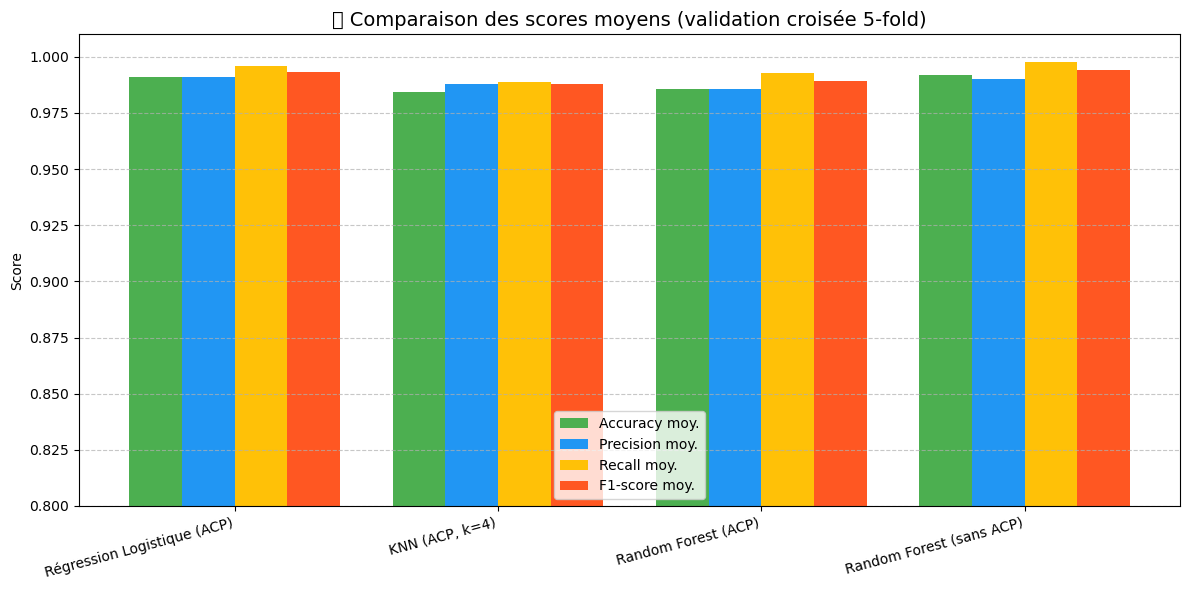

In [165]:
import matplotlib.pyplot as plt

# 📊 Construction du graphique
metrics = ["Accuracy moy.", "Precision moy.", "Recall moy.", "F1-score moy."]
colors = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722']

# Création d'un graphique en barres pour chaque métrique
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(df_scores2))
bar_width = 0.2

for i, metric in enumerate(metrics):
    ax.bar(
        [p + bar_width * i for p in x],
        df_scores2[metric],
        width=bar_width,
        label=metric,
        color=colors[i]
    )

# 🏷️ Paramètres du graphique
ax.set_title("📊 Comparaison des scores moyens (validation croisée 5-fold)", fontsize=14)
ax.set_xticks([p + bar_width * 1.5 for p in x])
ax.set_xticklabels(df_scores2.index, rotation=15, ha='right')
ax.set_ylim(0.8, 1.01)
ax.set_ylabel("Score")
ax.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\933135227.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


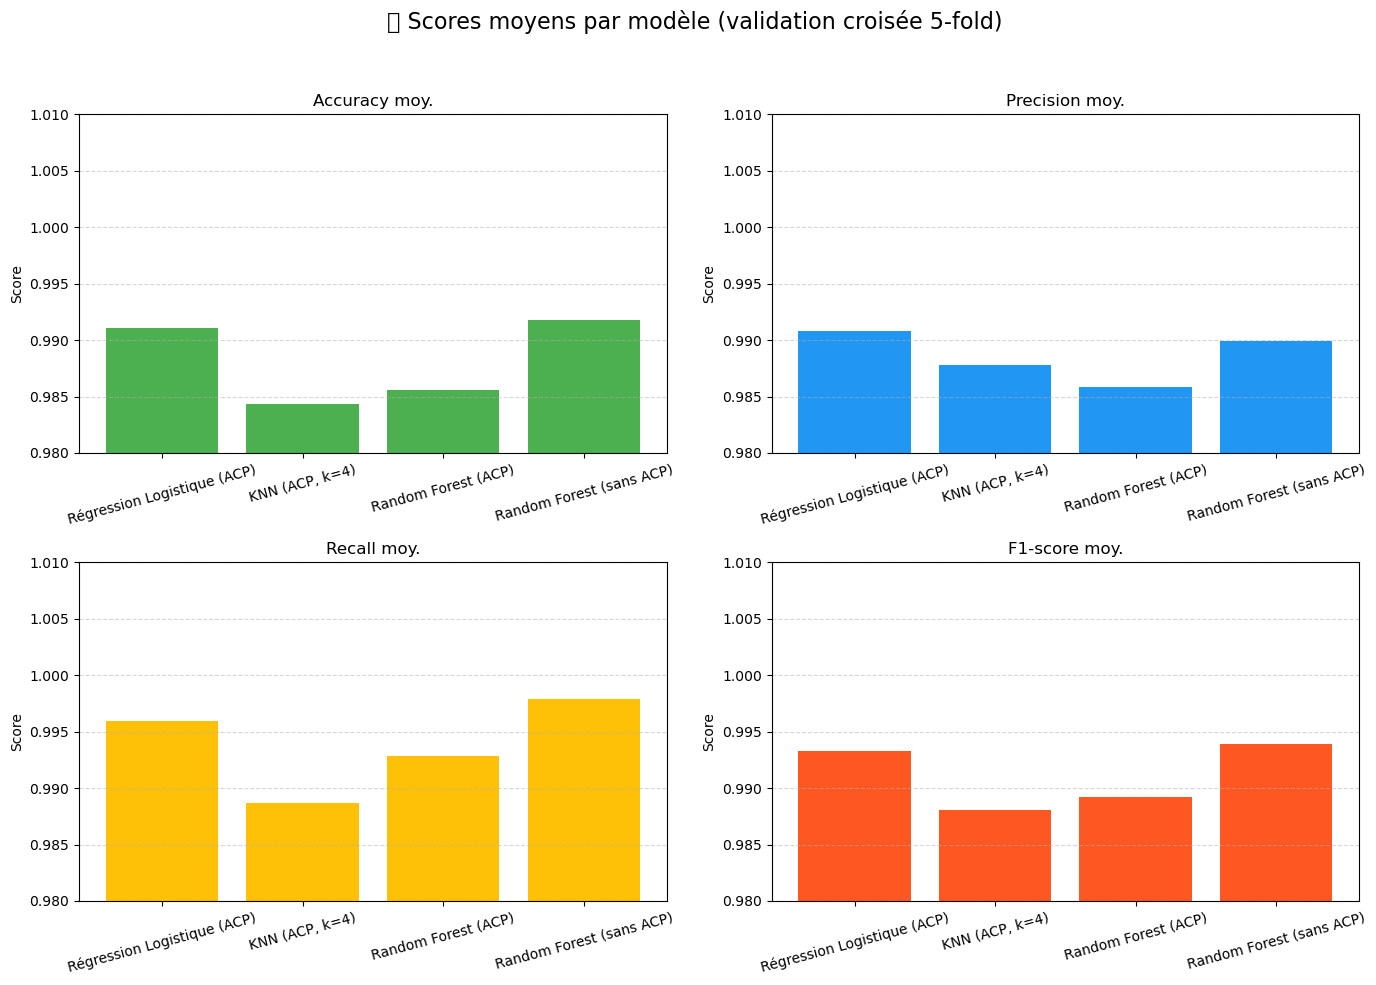

In [166]:
import matplotlib.pyplot as plt

# 📊 Données à tracer
metrics = ["Accuracy moy.", "Precision moy.", "Recall moy.", "F1-score moy."]
colors = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722']

# Création des sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].bar(df_scores2.index, df_scores2[metric], color=colors[i])
    axes[i].set_title(f"{metric}", fontsize=12)
    axes[i].set_ylim(0.98, 1.01)
    axes[i].set_ylabel("Score")
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# 🏷️ Mise en page
fig.suptitle("📊 Scores moyens par modèle (validation croisée 5-fold)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# 5 Choix du modèle 

### Métrique	Ce qu’elle mesure :
### Accuracy	Part des bonnes prédictions sur l’ensemble des observations
### Precision	Parmi les billets prédits comme faux, combien sont réellement faux ?
### Recall	    Parmi les billets vraiment faux, combien ont été bien détectés comme tels ?
### F1-score	Moyenne harmonique entre précision et rappel (équilibre entre les deux)

### Random Forest (sans ACP) —  Meilleur global
### Accuracy = 99.18% : Très peu d’erreurs.

### Recall = 99.79% : Presque tous les faux billets sont détectés.

### F1-score = 0.9939 : Excellent équilibre entre precision et recall.

### Interprétation : C’est le modèle le plus performant sans réduction de dimension, ce qui indique que la structure complète des données est très utile pour les arbres de décision.

### Régression Logistique (ACP) — Très bon aussi
### Accuracy = 99.11%

### Recall = 99.59%

### F1-score = 0.9933

### Interprétation : Excellent résultat avec réduction de dimension. Plus léger et rapide à entraîner, il reste robuste. L’ACP n’a pas dégradé la performance.

### KNN (ACP, k=4) — Légèrement en retrait
### Accuracy = 98.43%

### F1-score = 0.9881

### Interprétation : Correct mais un peu moins précis. Le KNN est sensible à la structure locale des données, qui peut être un peu altérée par l’ACP.

### Random Forest (avec ACP) — Bon compromis
### Accuracy = 98.56%

### Recall = 99.28%

### Interprétation : Très bon détecteur de faux billets aussi, mais la réduction de dimension a un peu limité ses performances par rapport à la version sans ACP.

### conclusion : pour maximiser la detection de faux billets se diriger vers le modèle random forest sans ACP (meilleur recall et F1_score)

# 5.1 Choix de la data (Comparaison score entre dataframe implémenté ou tronqué)

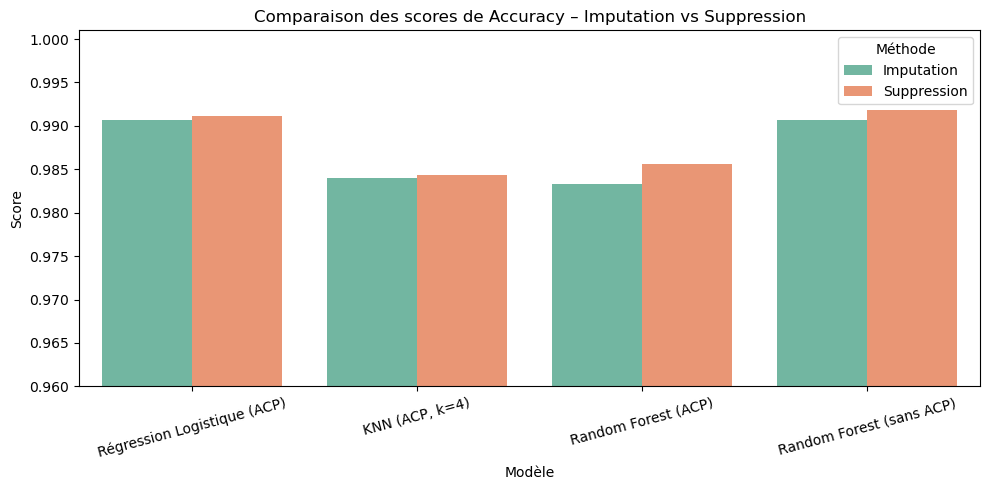

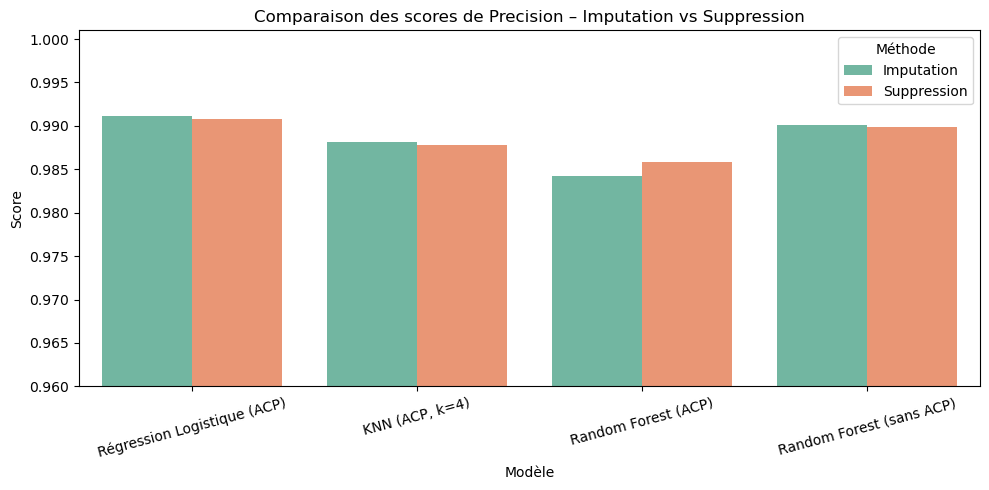

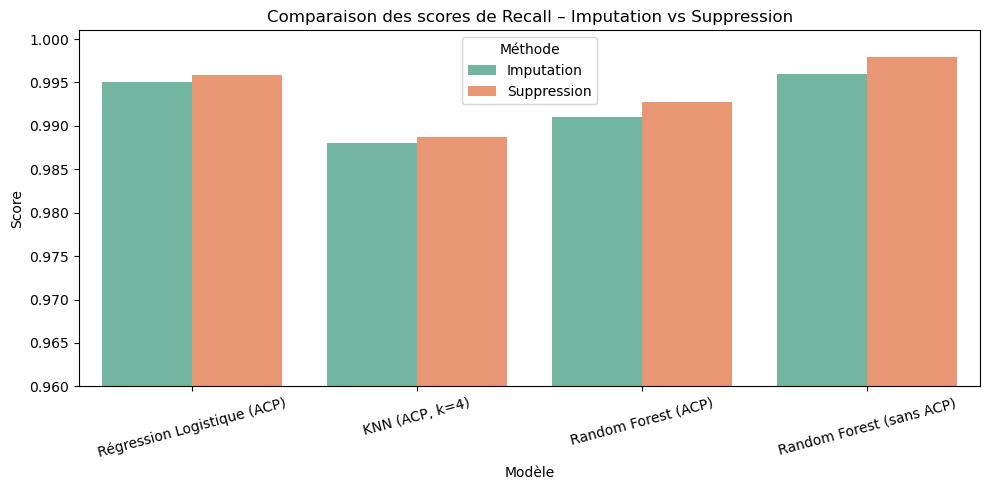

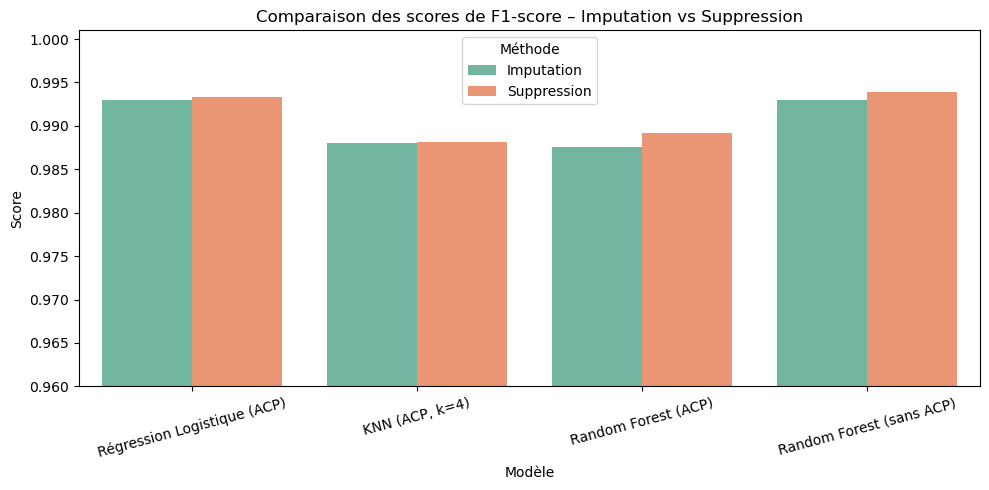

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ajouter la colonne 'Modèle' 
model_names = ["Régression Logistique (ACP)", "KNN (ACP, k=4)", "Random Forest (ACP)", "Random Forest (sans ACP)"]
df_scores1["Modèle"] = model_names
df_scores2["Modèle"] = model_names

# Ajouter la colonne 'Méthode' 
df_scores1["Méthode"] = "Imputation"
df_scores2["Méthode"] = "Suppression"

# Fusion des deux jeux de scores
df_scores = pd.concat([df_scores1, df_scores2], ignore_index=True)

# Transformation longue
df_melted = df_scores.melt(
    id_vars=["Modèle", "Méthode"],
    value_vars=["Accuracy moy.", "Precision moy.", "Recall moy.", "F1-score moy."],
    var_name="Métrique",
    value_name="Score"
)

# Simplification du nom des colonnes
df_melted["Métrique"] = df_melted["Métrique"].str.replace(" moy.", "", regex=False)

# Affichage des graphiques (un par métrique)
import matplotlib.pyplot as plt
import seaborn as sns

for metric in df_melted["Métrique"].unique():
    plt.figure(figsize=(10, 5))
    data = df_melted[df_melted["Métrique"] == metric]
    sns.barplot(data=data, x="Modèle", y="Score", hue="Méthode", palette="Set2")
    plt.title(f"Comparaison des scores de {metric} – Imputation vs Suppression")
    plt.xticks(rotation=15)
    plt.ylim(0.96, 1.001)
    plt.tight_layout()
    plt.legend(title="Méthode")
    plt.show()


### on notera tout de meme un leger avatange en precision avec le dataframe implémenté avec respectivement une precision de +0.003 en KNN et regression logistique et +0.002 en Random forest sans ACP sinon pour tout le reste le dataframe avec les données brutes tronquées est meilleur

# 5.2 Conclusion rédigée

## Régression logistique (ACP)
### La régression logistique, précédée d’une standardisation et d’une réduction dimensionnelle par ACP (5 composantes), atteint une accuracy moyenne de 99,11 %, avec une précision de 99,08 %, un rappel de 99,59 % et un F1-score de 99,33 % en validation croisée 5-fold. Ces performances témoignent d’une excellente capacité du modèle à distinguer les vrais billets des faux, même après projection des données dans un espace réduit. L’ACP contribue ici à limiter le risque de surapprentissage tout en conservant une forte capacité discriminante.

## K-plus proches voisins (KNN, ACP)
### Le modèle KNN, appliqué après standardisation et ACP, avec un nombre optimal de voisins fixé à 4, obtient une accuracy moyenne de 98,43 %, une précision de 98,78 %, un rappel de 98,87 % et un F1-score de 98,81 %. Bien que légèrement inférieur à la régression logistique, il montre une bonne capacité de classification, mais sa dépendance à la structure locale des données le rend plus sensible aux variations et au bruit.

## Forêt aléatoire (ACP)
### La forêt aléatoire, appliquée après standardisation et ACP, affiche une accuracy moyenne de 98,56 %, une précision de 98,58 %, un rappel de 99,28 % et un F1-score de 98,92 %. L’utilisation de l’ACP permet ici de réduire la dimensionnalité, mais la légère perte d’information par rapport au modèle sans ACP se traduit par une performance légèrement inférieure, bien que toujours excellente.

## Forêt aléatoire (sans ACP)
### La forêt aléatoire appliquée directement sur les variables standardisées, sans réduction dimensionnelle, obtient la meilleure performance globale : accuracy moyenne de 99,18 %, précision de 98,99 %, rappel de 99,79 % et F1-score de 99,39 %. L’absence d’ACP lui permet de tirer pleinement parti de toutes les informations présentes dans les variables d’origine, expliquant ses scores légèrement supérieurs aux autres modèles supervisés.

# Conclusion

### Le modèle Random Forest sans ACP a été retenu car il offre un excellent compromis entre précision, rappel et robustesse. Avec un recall de 99,79 %, il minimise drastiquement les faux négatifs (c’est-à-dire les faux billets classés à tort comme vrais), ce qui est critique dans un contexte de détection de fraude. Par ailleurs, il conserve une précision élevée (98,99 %), ce qui limite aussi les faux positifs, évitant ainsi de rejeter des billets authentiques.

### L’absence d’ACP permet de conserver l’intégralité de l’information portée par les variables d’origine, ce qui améliore l’interprétabilité des résultats et facilite la mise en production. Enfin, la nature même de la Random Forest lui confère une grande robustesse face aux données bruitées et aux valeurs extrêmes, assurant des performances stables sur de nouveaux jeux de données.

### En résumé : la Random Forest sans ACP est non seulement la plus performante mais aussi la plus robuste, et donc le meilleur choix pour un déploiement opérationnel dans ce contexte.


# 6 Sauvegarde du modèle

In [183]:
import joblib
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Jeu final : df_complete (déjà nettoyé : margin_low non-null)
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df_complete[features]
y = df_complete['is_genuine']

# Pipeline final
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])

# Entraînement sur TOUT df_complete
rf_pipeline.fit(X, y)

# Sauvegarde du pipeline et des features utilisées
joblib.dump({"pipeline": rf_pipeline, "features": features}, "rf_no_pca_pipeline.joblib")
print(" Modèle sauvegardé : rf_no_pca_pipeline.joblib")


 Modèle sauvegardé : rf_no_pca_pipeline.joblib
